# Balanced Dataset: Sentinel-2 (all bands) + Sentinel-1 

In the first part of the notebook, we calculate errors (MSE, MAE, R2-score) with various classical methods: 

- Linear regression
- Random Forest 
- Optimized LR and RF with Grid Search 

Results obtained (prior to optimization): 

###### Linear Regression (Sentinel-2 + Sentinel-1):
- Mean Squared Error: 6.88   (with Grid Search 6.88) 
- Mean Absolute Error: 2.22
- R-squared: 0.13               (with Grid Search 0.13)

###### Random Forest (Sentinel-2 + Sentinel-1):
- Mean Squared Error: 6.37       (with Grid Search 6.35)
- Mean Absolute Error: 2.08
- R-squared: 0.19                (with Grid Search 0.19)


In the second part of the dataset I enrich the dataset with extra features (various indices related to Sentinel-1 and Sentinel-2). I recalculate the classical errors (LR, RF, LR and RF optimized with Grid Search), also PCA and REF. 

The best results for Random Forest found so far are the following: 
###### Random Forest (All Sentinels + All Indices + REF): 
- Mean squared error: 6.32    (after Grid Search 6.26) 
- Mean absolute error: 2.07   (after Grid Search 2.07)
- R2 score: 0.19              (after Grid Search 0.19489)

## Attempt 1: Enriched Dataset: Sentinel-2 + Sentinel-1 + Indices related to Sentinel-1 
We notice that Linear Regression errors (MSE, MAE) go slightly down, while the Random Forest errors (MSE, MAE) go slightly up. 

##### Linear Regression (Sentinel-2 + Sentinel-1 + Indices-1):
- Mean Squared Error: 6.82          
- Mean Absolute Error: 2.20
- R-squared: 0.13

##### Random Forest (Sentinel-2 + Sentinel-1 + Indices-1):
- Mean Squared Error: 6.40
- Mean Absolute Error: 2.09
- R-squared: 0.19

## Attempt 2: Enriched Dataset: Sentinel-2 + Sentinel-1 + Indices-1 + Indices of Sentinel-2 

##### Linear Regression (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):
- Mean Squared Error: 6.82       (with Grid Search: 6.81)
- Mean Absolute Error: 2.20      (with Grid Search: same)
- R-squared: 0.13                (with Grid Search: same) 

##### Random Forest (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):
- Mean Squared Error: 6.39       (with Grid Search 6.35) 
- Mean Absolute Error: 2.08      (with Grid Search 2.09) 
- R-squared: 0.19                (with Grid Search 0.19) 

### PCA on  the enriched dataset Sentinel-2 + Sentinel-1 + Indices-1 + Indices-2 

I run PCA on this dataset (X) and calculated the error on the dataset (X_pca) obtained after PCA:  

##### Linear Regression (All Sentinels + All Indices + PCA):
- Mean Squared Error: 6.92
- Mean Absolute Error: 2.23
- R-squared: 0.12

##### Random Forest (All Sentinels + All Indices + PCA):
- Mean Squared Error: 6.59
- Mean Absolute Error: 2.13
- R-squared: 0.16

### REF on  the enriched dataset Sentinel-2 + Sentinel-1 + Indices-1 + Indices-2  (Lowest error found)

I run REF on X and calculated the error on X_ref. Here's the most important features ranked (1 = most important):
- Sentinel-2 B2: 1
- Sentinel-2 B3: 5
- Sentinel-2 B4: 3
- Sentinel-2 B5: 8
- Sentinel-2 B6: 4
- Sentinel-2 B7: 1
- Sentinel-2 B8: 1
- Sentinel-2 B11: 6
- Sentinel-2 B12: 1
- Sentinel-1 VV: 12
- Sentinel-1 VH: 7
- sigma_VV: 9
- sigma_VH: 11
- VH/VV: 2
- NDVI(VH|VV): 1
- UAI(VH|VV): 1
- NDVI(Sent-2): 10
- NDBI: 1
- NDWI: 1
- NDSI: 1
- UAI(Sent-2): 1
 

##### Random Forest (All Sentinels + All Indices + REF): 
- Mean squared error: 6.32    (after Grid Search 6.26) 
- Mean absolute error: 2.07   (after Grid Search 2.07)
- R2 score: 0.19              (after Grid Search 0.19489)


In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from PIL import Image
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [69]:
def custom_acc(Y_pred, Y_test, penalty_wrong=False):
    bin_upper_bounds = np.arange(11)
    Y_test_bins = np.zeros((len(Y_test)),dtype=int)
    Y_pred_bins = np.zeros((len(Y_pred)),dtype=int)
    totscore = 0
    for i in range(len(Y_test)):
        for j in range(11):
            if Y_test[i] >= bin_upper_bounds[j]:
                Y_test_bins[i] = j
            if Y_pred[i] >= bin_upper_bounds[j]:
                Y_pred_bins[i] = j
        scores_diff = np.abs(Y_test_bins[i] - Y_pred_bins[i])
        if scores_diff == 0:
            totscore += 1.
        elif scores_diff == 1:
            totscore += 2./3.
        elif scores_diff == 2:
            totscore += 1./3
        if penalty_wrong:
            if scores_diff == 4:
                totscore -= 1/.3
            elif scores_diff == 5:
                totscore -=2./3
            else:
                totscore -=1
    avscore = totscore / len(Y_test)
    return avscore
        

In [3]:
data = np.load('features_balanced_v2.npy')

# load the numpy array into a pandas dataframe
df = pd.DataFrame(data)

df.head()
df.describe()

# extract the last column as a numpy array
y = df.iloc[:, -1].values
print('Here is the shape of y', y.shape)

# extract all other columns as a numpy array
X = df.iloc[:, :-1].values

# print the shape of the new X array
print('Here is the shape of X:', X.shape)

Here is the shape of y (110000,)
Here is the shape of X: (110000, 23)


In [74]:
data_old = np.load("../data/pixels_features_shuffled.npy")
X_old = data_old[:,:-1]
y_old = data_old[:,-1]

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,56.0,81.0,82.0,123.0,162.0,178.0,184.0,185.0,158.0,104.0,...,0.0,25.0,0.0,3.0,0.0,30.0,0.0,8.0,0.0,11.429655
1,82.0,92.0,105.0,149.0,147.0,147.0,138.0,178.0,158.0,151.0,...,-5.0,0.0,12.0,0.0,5.0,0.0,28.0,0.0,1.0,6.709934
2,44.0,57.0,61.0,118.0,155.0,159.0,138.0,181.0,167.0,201.0,...,28.0,0.0,3.0,0.0,32.0,0.0,-5.0,0.0,38.0,6.738213
3,94.0,106.0,127.0,115.0,116.0,118.0,135.0,198.0,189.0,160.0,...,-6.0,0.0,-23.0,0.0,-6.0,0.0,-32.0,0.0,-19.0,5.995123
4,17.0,29.0,20.0,58.0,156.0,173.0,169.0,123.0,62.0,125.0,...,0.0,9.0,0.0,7.0,0.0,7.0,0.0,3.0,0.0,9.175013


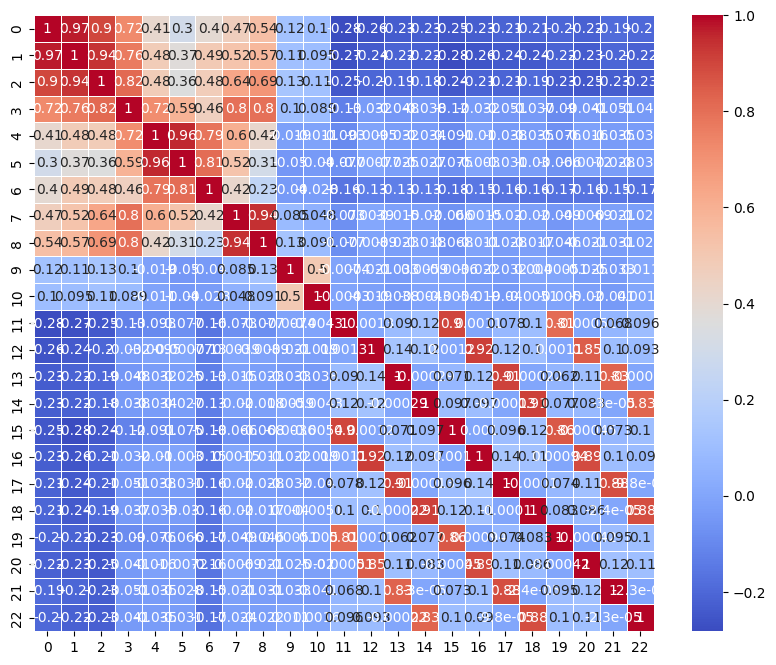

In [5]:
### Visualize correlations between columns of X 
import seaborn as sns
# create a correlation matrix
corr_matrix = np.corrcoef(X, rowvar=False)

# create a larger plot
fig, ax = plt.subplots(figsize=(10, 8))

# create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

# show plot
plt.show()

In [75]:
##### Runs various models on X and y prepared above 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_old = scaler.fit_transform(X_old)

# Split the data into training and testing sets
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_old, y_old.ravel(), test_size=0.2, random_state=42)

do_lr = False
do_dt = False
do_rf = True
do_gb = False

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models on the training data
if do_lr:
    lr.fit(X_train_o, y_train_o)
    y_pred_lr = lr.predict(X_test_o)
if do_dt:
    dt.fit(X_train_o, y_train_o)
    y_pred_dt_o = dt.predict(X_test_o)
if do_rf:
    rf.fit(X_train_o, y_train_o)
    y_pred_rf_o = rf.predict(X_test_o)
if do_gb:
    gb.fit(X_train_o, y_train_o)
    y_pred_gb_o = gb.predict(X_test_o)

# Make predictions on the test data

# Evaluate the models using mean squared error and R-squared
if do_lr:
    print("Linear Regression (Sentinel-2 + Sentinel-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test_o, y_pred_lr_o)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test_o, y_pred_lr_o)))
    print("R-squared: {:.2f}".format(r2_score(y_test_o, y_pred_lr_o)))
    print()

if do_dt:
    print("Decision Tree (Sentinel-2 + Sentinel-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test_o, y_pred_dt_o)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test_o, y_pred_dt_o)))
    print("R-squared: {:.2f}".format(r2_score(y_test_o, y_pred_dt_o)))
    print()
    
if do_rf:
    print("Random Forest (Sentinel-2 + Sentinel-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test_o, y_pred_rf_o)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test_o, y_pred_rf_o)))
    print("R-squared: {:.2f}".format(r2_score(y_test_o, y_pred_rf_o)))
    print()

if do_gb:
    print("Gradient Boosting (Sentinel-2 + Sentinel-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test_o, y_pred_gb_o)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test_o, y_pred_gb_o)))
    print("R-squared: {:.2f}".format(r2_score(y_test_o, y_pred_gb_o)))
    print()


Random Forest (Sentinel-2 + Sentinel-1):
Mean Squared Error: 21.87
Mean Absolute Error: 2.09
R-squared: 0.11



In [76]:
acc = custom_acc(y_pred_rf_o, y_test_o)
print(acc)

0.602433367787189


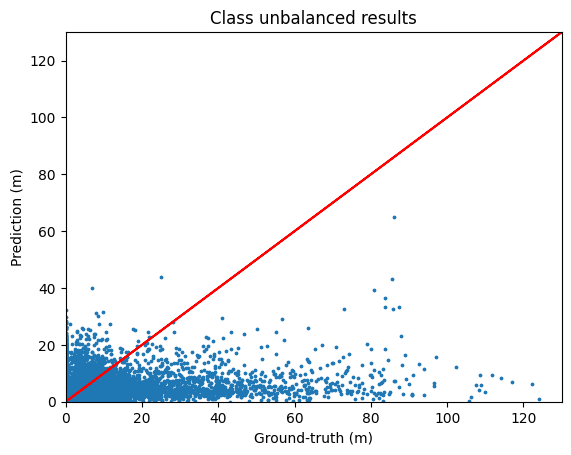

In [86]:
plt.scatter(y_test_o, y_pred_rf_o,s=3)
plt.plot(y_2_test, y_2_test,color='r')
plt.ylim(0,130)
plt.xlim(0,130)
plt.xlabel("Ground-truth (m)")
plt.ylabel("Prediction (m)")
plt.title("Class unbalanced results")
plt.savefig("Class_unbalanced_results.png")
plt.show()

In [45]:
##### Runs various models on X and y prepared above 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

do_lr = False
do_dt = False
do_rf = True
do_gb = False

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models on the training data
if do_lr:
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
if do_dt:
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
if do_rf:
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
if do_gb:
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)

# Make predictions on the test data

# Evaluate the models using mean squared error and R-squared
if do_lr:
    print("Linear Regression (Sentinel-2 + Sentinel-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_lr)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_lr)))
    print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_lr)))
    print()

if do_dt:
    print("Decision Tree (Sentinel-2 + Sentinel-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_dt)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_dt)))
    print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_dt)))
    print()
    
if do_rf:
    print("Random Forest (Sentinel-2 + Sentinel-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_rf)))
    print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_rf)))
    print()

if do_gb:
    print("Gradient Boosting (Sentinel-2 + Sentinel-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_gb)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_gb)))
    print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_gb)))
    print()


Random Forest (Sentinel-2 + Sentinel-1):
Mean Squared Error: 19.77
Mean Absolute Error: 1.56
R-squared: 0.88



In [70]:
acc = custom_acc(y_pred_rf, y_test)
print(acc)

0.8349242424242345


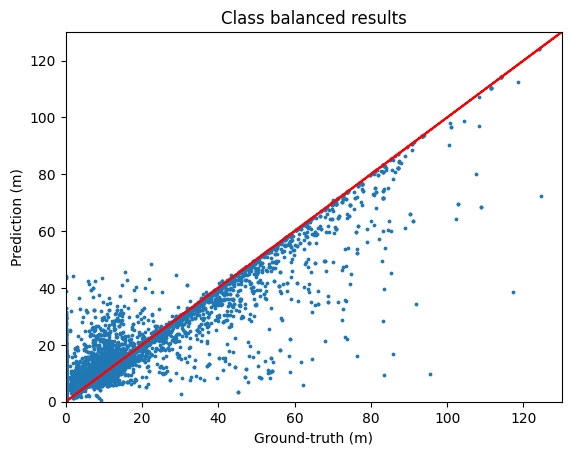

In [85]:
plt.scatter(y_test, y_pred_rf,s=3)
plt.plot(y_test, y_test,color='r')
plt.ylim(0,130)
plt.xlim(0,130)
plt.xlabel("Ground-truth (m)")
plt.ylabel("Prediction (m)")
plt.title("Class balanced results")
plt.savefig("Class_balanced_results.png")
plt.show()

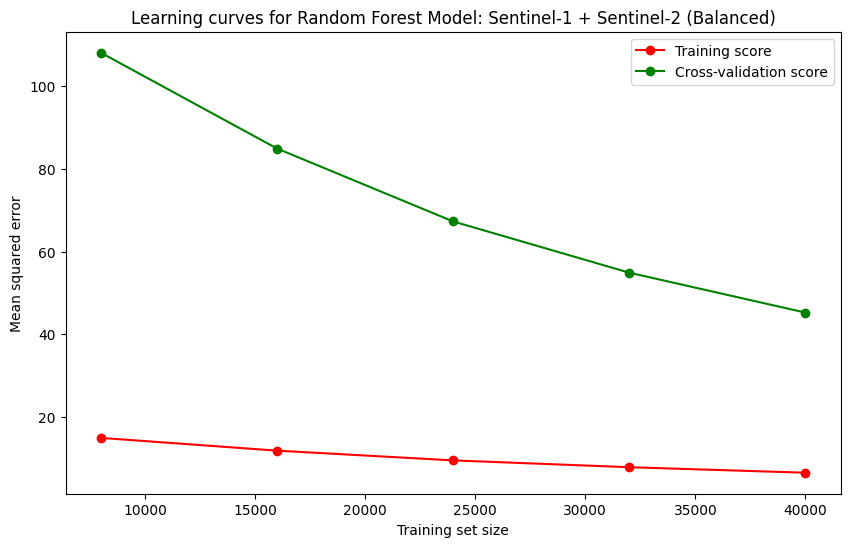

In [8]:
#### LESS DATA IN INPUT !!! 10000 rows 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X), size= 50000, replace=False)
X__subset = X[subset_idx]
y__subset = y[subset_idx]

# Create an instance of the Random Forest model
rf__model = RandomForestRegressor()

# Define the range of training set sizes to use
train__sizes = np.linspace(0.2, 1.0, 5)

# Calculate the learning curve for the Random Forest model
train__sizes, train__scores, test__scores = learning_curve(rf__model, X__subset, y__subset, cv=5, train_sizes=train__sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train__scores = -train__scores
test__scores = -test__scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train__scores_mean = np.mean(train__scores, axis=1)
train__scores_std = np.std(train__scores, axis=1)
test__scores_mean = np.mean(test__scores, axis=1)
test__scores_std = np.std(test__scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train__sizes, train__scores_mean, 'o-', color='r', label='Training score')
plt.plot(train__sizes, test__scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: Sentinel-1 + Sentinel-2 (Balanced)')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

In [ ]:
#### LESS DATA IN INPUT : Learning curve for mae

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X), size= 50000, replace=False)
X__subset = X[subset_idx]
y__subset = y[subset_idx]

# Create an instance of the Random Forest model
rf__model = RandomForestRegressor()

# Define the range of training set sizes to use
train__sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train__sizes, train__scores, test__scores = learning_curve(rf__model, X__subset, y__subset, cv=5, train_sizes=train__sizes, scoring='neg_mean_absolute_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train__scores = -train__scores
test__scores = -test__scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train__scores_mean = np.mean(train__scores, axis=1)
train__scores_std = np.std(train__scores, axis=1)
test__scores_mean = np.mean(test__scores, axis=1)
test__scores_std = np.std(test__scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train__sizes, train__scores_mean, 'o-', color='r', label='Training score')
plt.plot(train__sizes, test__scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: Sentinel-1 + Sentinel-2 (Balanced)')
plt.xlabel('Training set size')
plt.ylabel('Mean absolute error')
plt.legend(loc='best')
plt.show()

In [ ]:
### Learning Curve for the regression model 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

# Create an instance of the Linear Regression model
lr_model = LinearRegression()

# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Linear Regression model
train_sizes, train_scores, test_scores = learning_curve(lr_model, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error')

# Convert the negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning curves for Linear Regression Model')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.show()


In [ ]:
# Learning curve for the Decision Tree model 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve

# Convert y to a 1d array using ravel()
y = np.ravel(y)

# Create an instance of the Decision Tree model
tree_model = DecisionTreeRegressor()

# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Decision Tree model
train_sizes, train_scores, test_scores = learning_curve(tree_model, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error')

# Convert the negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning curves for Decision Tree Model')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()


In [ ]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "R-squared:", r2)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the best hyperparameters
params = {'max_depth': 15, 'n_estimators': 300}

# Create an instance of the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(**params)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Number of training examples')
plt.ylabel('Mean squared error')
plt.title('Random Forest Learning Curve Sentinel-1 and Sentinel-2') 
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the best hyperparameters
params = {'max_depth': 15, 'n_estimators': 300}

# Create an instance of the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(**params)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Number of training examples')
plt.ylabel('Mean absolute error')
plt.title('Random Forest Learning Curve Sentinel-1 and Sentinel-2') 
plt.legend()
plt.show()


## Enrich the database with Sentinel-1 indices for urban landscape

Now I try to enlarge the dataframe plugging in extra columns with relevant indices. 

In [19]:
import numpy as np

def generate_X_rich(X):
    # Calculate backscatter coefficients
    sigma_VV = 10**(X[:,9]/10) 
    sigma_VH = 10**(X[:,10]/10)
    
    # Calculate indices    
    epsilon = 1e-6
    ratio_VH_VV = X[:,10]/(X[:,9] + epsilon)
    NDVI = (sigma_VH - sigma_VV)/(sigma_VH + sigma_VV)
    UAI = 10*np.log10(sigma_VV**2 + sigma_VH**2) # ranked 1 
    
    # Create new numpy array
    X_rich = np.hstack((X, sigma_VV.reshape(-1,1), sigma_VH.reshape(-1,1), ratio_VH_VV.reshape(-1,1), NDVI.reshape(-1,1), UAI.reshape(-1,1)))
    
    return X_rich


In [20]:
X_rich = generate_X_rich(X)
# load the numpy array into a pandas dataframe
#df = pd.DataFrame(data_large)

print(X_rich.shape)
print(X.shape)

(110000, 28)
(110000, 23)


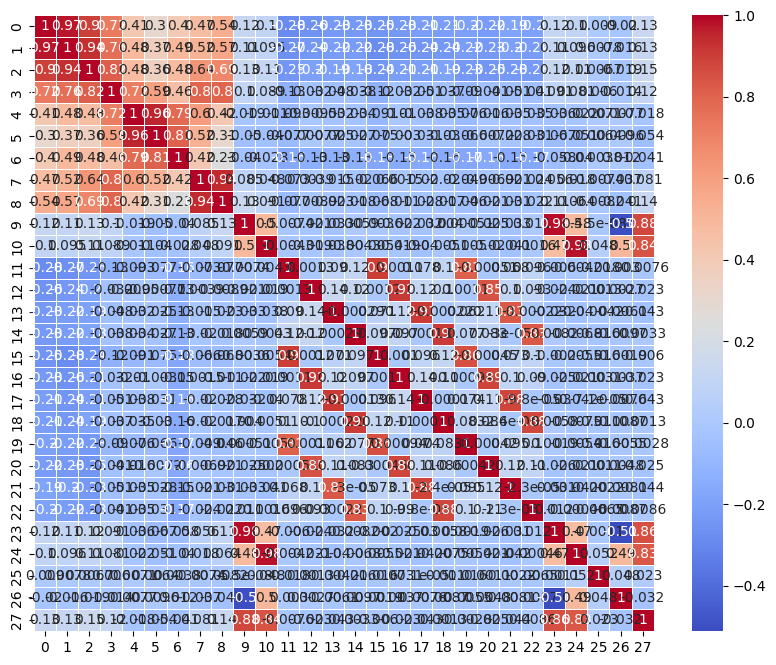

In [21]:
### Visualize correlations between columns of X 
import seaborn as sns
# create a correlation matrix
corr_matrix = np.corrcoef(X_rich, rowvar=False)

# create a larger plot
fig, ax = plt.subplots(figsize=(10, 8))

# create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

# show plot
plt.show()


In [22]:
##### Runs various models on X and y prepared above 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_rich = scaler.fit_transform(X_rich)

# Split the data into training and testing sets
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_rich, y.ravel(), test_size=0.2, random_state=42)

# Initialize the models
if do_lr:
    lr = LinearRegression()
    lr.fit(X_2_train, y_2_train)
    y_2_pred_lr = lr.predict(X_2_test)
if do_dt:
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_2_train, y_2_train)
    y_2_pred_dt = dt.predict(X_2_test)
if do_rf:
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_2_train, y_2_train)
    y_2_pred_rf = rf.predict(X_2_test)
if do_gb:
    gb = GradientBoostingRegressor(random_state=42)
    gb.fit(X_2_train, y_2_train)
    y_2_pred_gb = gb.predict(X_2_test)


# Train the models on the training data

# Make predictions on the test data

# Evaluate the models using mean squared error and R-squared
if do_lr:
    print("Linear Regression (Sentinel-2 + Sentinel-1 + Indices-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_lr)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_lr)))
    print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_lr)))
    print()

if do_dt:
    print("Decision Tree (Sentinel-2 + Sentinel-1 + Indices-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_dt)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_dt)))
    print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_dt)))
    print()
    

if do_rf:
    print("Random Forest (Sentinel-2 + Sentinel-1 + Indices-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_rf)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_rf)))
    print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_rf)))
    print()

if do_gb:
    print("Gradient Boosting (Sentinel-2 + Sentinel-1 + Indices-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_gb)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_gb)))
    print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_gb)))
    print()


Random Forest (Sentinel-2 + Sentinel-1 + Indices-1):
Mean Squared Error: 19.64
Mean Absolute Error: 1.56
R-squared: 0.88



In [73]:
acc = custom_acc(y_2_test, y_2_pred_rf)
print(acc)

0.8371060606060533


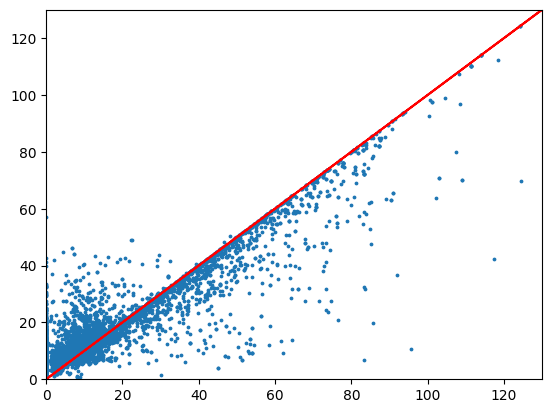

In [71]:
plt.scatter(y_2_test, y_2_pred_rf,s=3)
plt.plot(y_2_test, y_2_test,color='r')
plt.ylim(0,130)
plt.xlim(0,130)
plt.show()

In [ ]:
### LESS DATA IN INPUT !!! 10000 rows 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X_rich), size= 50000, replace=False)
X_2_subset = X_rich[subset_idx]
y_2_subset = y[subset_idx]

# Create an instance of the Random Forest model
rf_2_model = RandomForestRegressor()

# Define the range of training set sizes to use
train_2_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train_2_sizes, train_2_scores, test_2_scores = learning_curve(rf_2_model, X_2_subset, y_2_subset, cv=5, train_sizes=train_2_sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train_2_scores = -train_2_scores
test_2_scores = -test_2_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_2_scores_mean = np.mean(train_2_scores, axis=1)
train_2_scores_std = np.std(train_2_scores, axis=1)
test_2_scores_mean = np.mean(test_2_scores, axis=1)
test_2_scores_std = np.std(test_2_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_2_sizes, train_2_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_2_sizes, test_2_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: Sentinel-1 + Sentinel-2 + Indices-1  Balanced)')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

## Add also Sentinel-2 indices 

In [24]:
### Add indices inspired by Sentinel-2 

import numpy as np

def generate_X_rich_S2(X):
    # Calculate indices
    NDVI = (X[:,7] - X[:,3]) / (X[:,7] + X[:,3] + np.finfo(float).eps)  #ranked 1
    NDBI = (X[:,11] - X[:,7]) / (X[:,11] + X[:,7] + np.finfo(float).eps)
    NDWI = (X[:,3] - X[:,7]) / (X[:,3] + X[:,7] + np.finfo(float).eps)
    NDSI = (X[:,3] - X[:,11]) / (X[:,3] + X[:,11] + np.finfo(float).eps)
    UAI = (2*X[:,7] - X[:,2] - X[:,1]) / (2*X[:,7] + X[:,2] + X[:,1] + np.finfo(float).eps)  #ranked 1
    
    # Create new numpy array
    X_rich_S2 = np.hstack((X, NDVI.reshape(-1,1), NDBI.reshape(-1,1), NDWI.reshape(-1,1), NDSI.reshape(-1,1), UAI.reshape(-1,1)))
    
    return X_rich_S2


In [25]:
X_rich_S2 = generate_X_rich_S2(X_rich)


print(X_rich_S2.shape)
print(X_rich.shape)
print(X.shape)

(110000, 33)
(110000, 28)
(110000, 23)


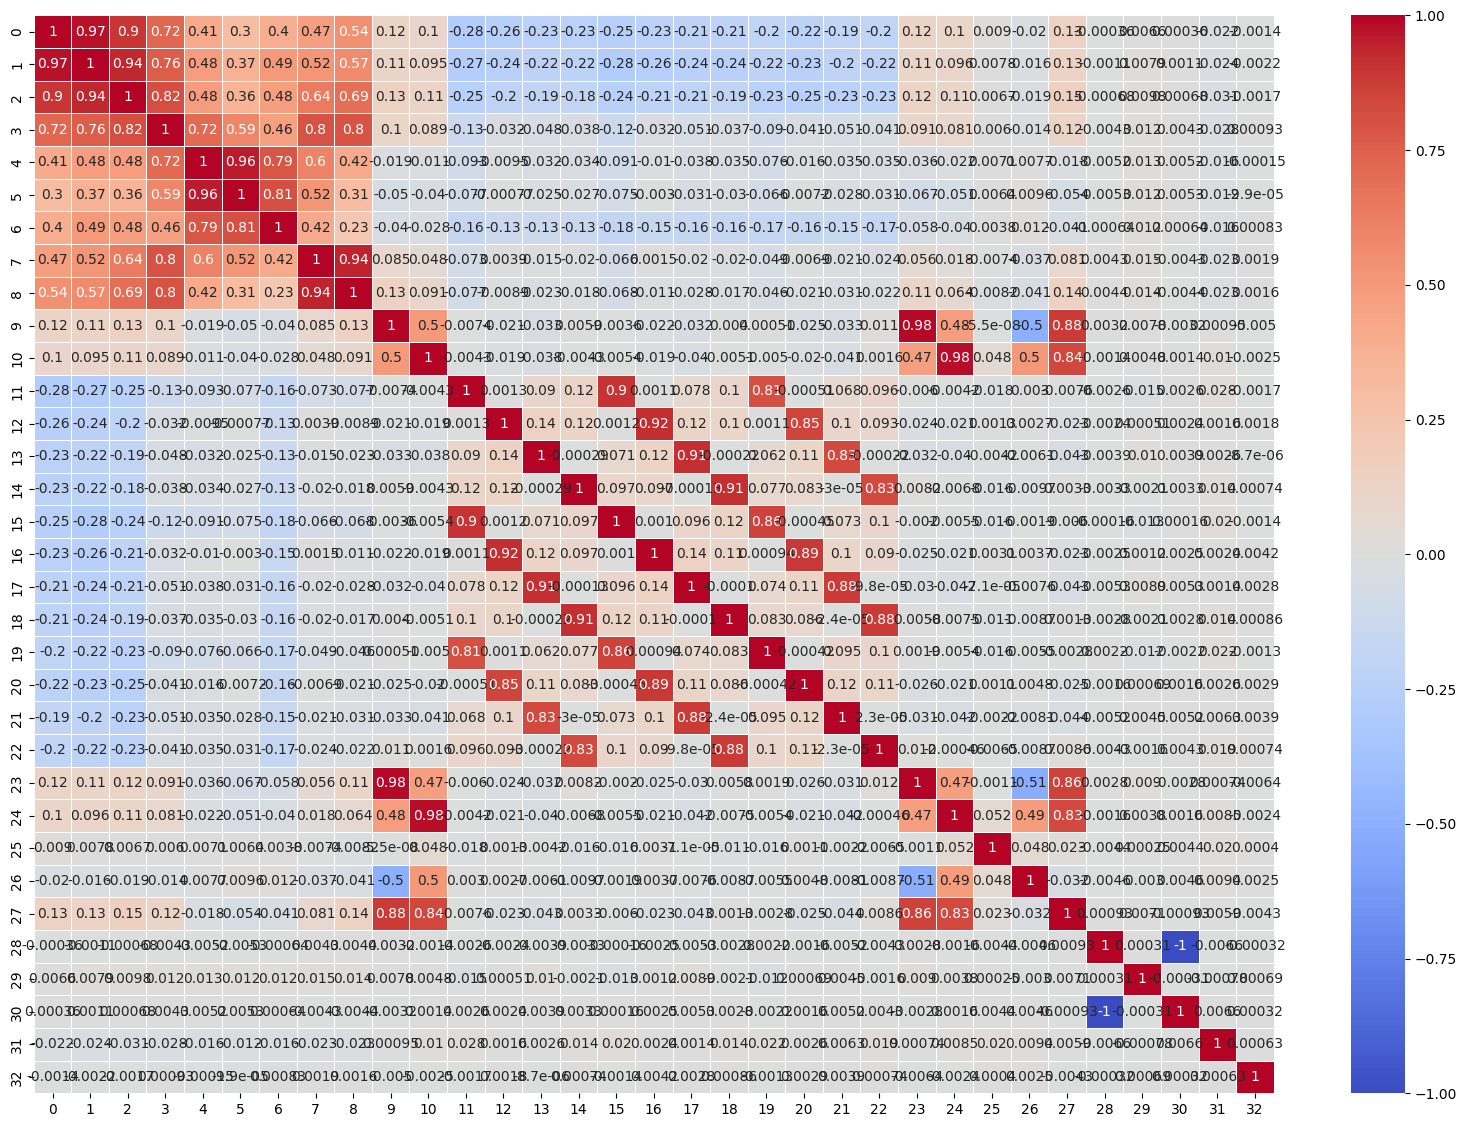

In [26]:
### Visualize correlations between columns of X 
import seaborn as sns
# create a correlation matrix
corr_matrix = np.corrcoef(X_rich_S2, rowvar=False)

# create a larger plot
fig, ax = plt.subplots(figsize=(20, 14))

# create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

# show plot
plt.show()


In [27]:
##### Runs various models on X and y prepared above 

##### Runs various models on X and y prepared above 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_rich_S2 = scaler.fit_transform(X_rich_S2)

# Split the data into training and testing sets
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_rich_S2, y.ravel(), test_size=0.2, random_state=42)

# Initialize the models
if do_lr:
    lr = LinearRegression()
    lr.fit(X_2_train, y_2_train)
    y_2_pred_lr = lr.predict(X_2_test)
if do_dt:
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_2_train, y_2_train)
    y_2_pred_dt = dt.predict(X_2_test)
if do_rf:
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_2_train, y_2_train)
    y_2_pred_rf = rf.predict(X_2_test)
if do_gb:
    gb = GradientBoostingRegressor(random_state=42)
    gb.fit(X_2_train, y_2_train)
    y_2_pred_gb = gb.predict(X_2_test)


# Train the models on the training data

# Make predictions on the test data

# Evaluate the models using mean squared error and R-squared
if do_lr:
    print("Linear Regression (Sentinel-2 + Sentinel-1 + Indices-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_lr)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_lr)))
    print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_lr)))
    print()

if do_dt:
    print("Decision Tree (Sentinel-2 + Sentinel-1 + Indices-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_dt)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_dt)))
    print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_dt)))
    print()
    

if do_rf:
    print("Random Forest (Sentinel-2 + Sentinel-1 + Indices-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_rf)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_rf)))
    print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_rf)))
    print()

if do_gb:
    print("Gradient Boosting (Sentinel-2 + Sentinel-1 + Indices-1):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_gb)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_gb)))
    print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_gb)))
    print()



Random Forest (Sentinel-2 + Sentinel-1 + Indices-1):
Mean Squared Error: 19.76
Mean Absolute Error: 1.56
R-squared: 0.88



In [77]:
acc = custom_acc(y_2_test, y_2_pred_rf)
print(acc)

0.8371060606060533


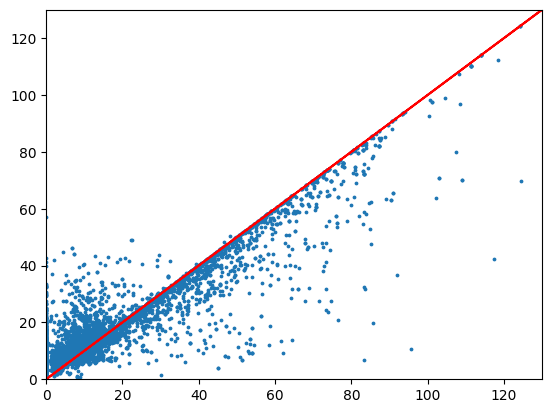

In [39]:
plt.scatter(y_2_test, y_2_pred_rf,s=3)
plt.plot(y_2_test, y_2_test,color='r')
plt.ylim(0,130)
plt.xlim(0,130)
plt.show()

In [ ]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_3_train, y_3_train)
    y_3_pred = grid_search.predict(X_3_test)
    mse = mean_squared_error(y_3_test, y_3_pred)
    mae = mean_absolute_error(y_3_test, y_3_pred)
    r2 = r2_score(y_3_test, y_3_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "MAE:", mae, "R-squared:", r2)

## Various Features Rankings: RFE and PCA 

In [28]:
### Principal Component Analysis (PCA)

import numpy as np
from sklearn.decomposition import PCA


# Define the number of principal components to keep
n_components_to_keep = 10

# Create the PCA object and fit the data
pca = PCA(n_components=n_components_to_keep)
pca.fit(X_rich_S2)

# Transform the data to the new feature space
X_pca = pca.transform(X_rich_S2)

# Print the explained variance of each principal component
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.19521092 0.11974404 0.09774624 0.08397457 0.08058878 0.06543967
 0.06144671 0.06044355 0.04562393 0.03077182]


In [29]:
# Print the explained variance of each principal component, rounded to 2 decimal places
explained_variance = pca.explained_variance_ratio_
explained_variance_rounded = np.round(explained_variance, 2)
print('Explained variance:', explained_variance_rounded)

# Get the weight matrix for the principal components
weights = np.round(pca.components_,2)
print("Weights:")
print(pd.DataFrame(weights))

# Get the weights for the first principal component
weights_1st = weights[0]
print("List for 1st PC:", np.round(weights_1st,2))

# Sort the weights in descending order
sorted_indices = np.argsort(weights_1st)[::-1]

# Print the names of the top features in the first principal component
feature_names = ['Sentinel-2 B2', 'Sentinel-2 B3', 'Sentinel-2 B4', 'Sentinel-2 B5', 'Sentinel-2 B6', 'Sentinel-2 B7',
                 'Sentinel-2 B8', 'Sentinel-2 B11', 'Sentinel-2 B12', 'Sentinel-1 VV', 'Sentinel-1 VH', 
                 'sigma_VV', 'sigma_VH', 'VH/VV', 'NDVI(VH|VV)', 'UAI(VH|VV)', 
                 'NDVI(Sent-2)', 'NDBI', 'NDWI', 'NDSI', 'UAI(Sent-2)']

print('Top features in the first principal component:')
df = pd.DataFrame({'Feature': feature_names, 'Weight': weights_1st})
df_sorted = df.sort_values('Weight', ascending=False)
print(df_sorted)


Explained variance: [0.2  0.12 0.1  0.08 0.08 0.07 0.06 0.06 0.05 0.03]
Weights:
     0     1     2     3     4     5     6     7     8     9   ...    23   
0  0.33  0.35  0.36  0.33  0.27  0.24  0.26  0.28  0.27  0.08  ...  0.07  \
1 -0.01 -0.02 -0.01 -0.04 -0.13 -0.14 -0.13 -0.05 -0.00  0.42  ...  0.42   
2  0.05  0.04 -0.00 -0.21 -0.22 -0.21 -0.05 -0.24 -0.21 -0.04  ... -0.03   
3  0.00 -0.00 -0.01 -0.04 -0.05 -0.05 -0.03 -0.04 -0.04  0.04  ...  0.04   
4 -0.01 -0.01 -0.02 -0.05 -0.05 -0.05 -0.02 -0.07 -0.06 -0.01  ... -0.01   
5 -0.02 -0.01 -0.01  0.00  0.04  0.05  0.04  0.02 -0.00 -0.06  ... -0.07   
6  0.02  0.01  0.02 -0.00 -0.06 -0.06 -0.06  0.03  0.05  0.29  ...  0.30   
7 -0.01 -0.01 -0.01  0.00  0.02  0.02  0.02 -0.00 -0.01 -0.13  ... -0.13   
8 -0.24 -0.19 -0.24 -0.14  0.39  0.49  0.47 -0.16 -0.35  0.12  ...  0.12   
9 -0.03 -0.02 -0.01 -0.01  0.01  0.01  0.01  0.01  0.00 -0.01  ... -0.01   

     24    25    26    27    28    29    30    31    32  
0  0.07  0.01 -0.01  0.0

ValueError: All arrays must be of the same length

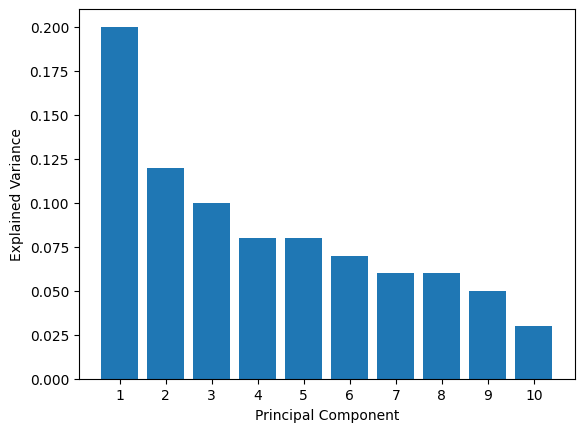

In [30]:
import matplotlib.pyplot as plt

# Plot the explained variance of each principal component
plt.bar(range(1, len(explained_variance_rounded) + 1), explained_variance_rounded)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(explained_variance_rounded) + 1))
plt.show()

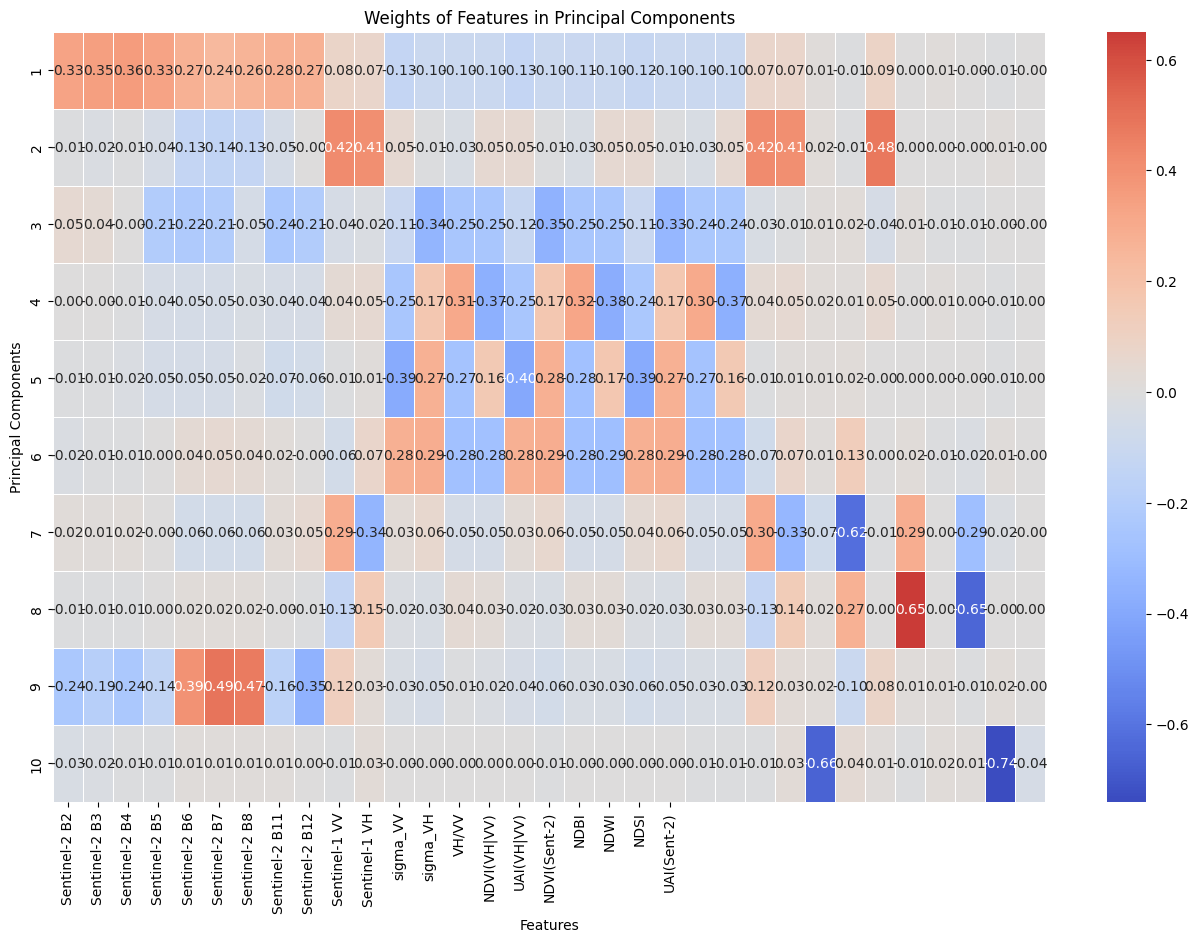

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the weight matrix
plt.figure(figsize=(16, 10))
sns.heatmap(weights, cmap='coolwarm', center=0, annot=True, linewidths=.5, fmt=".2f", xticklabels=feature_names, yticklabels=range(1,11))
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.title('Weights of Features in Principal Components')
plt.show()


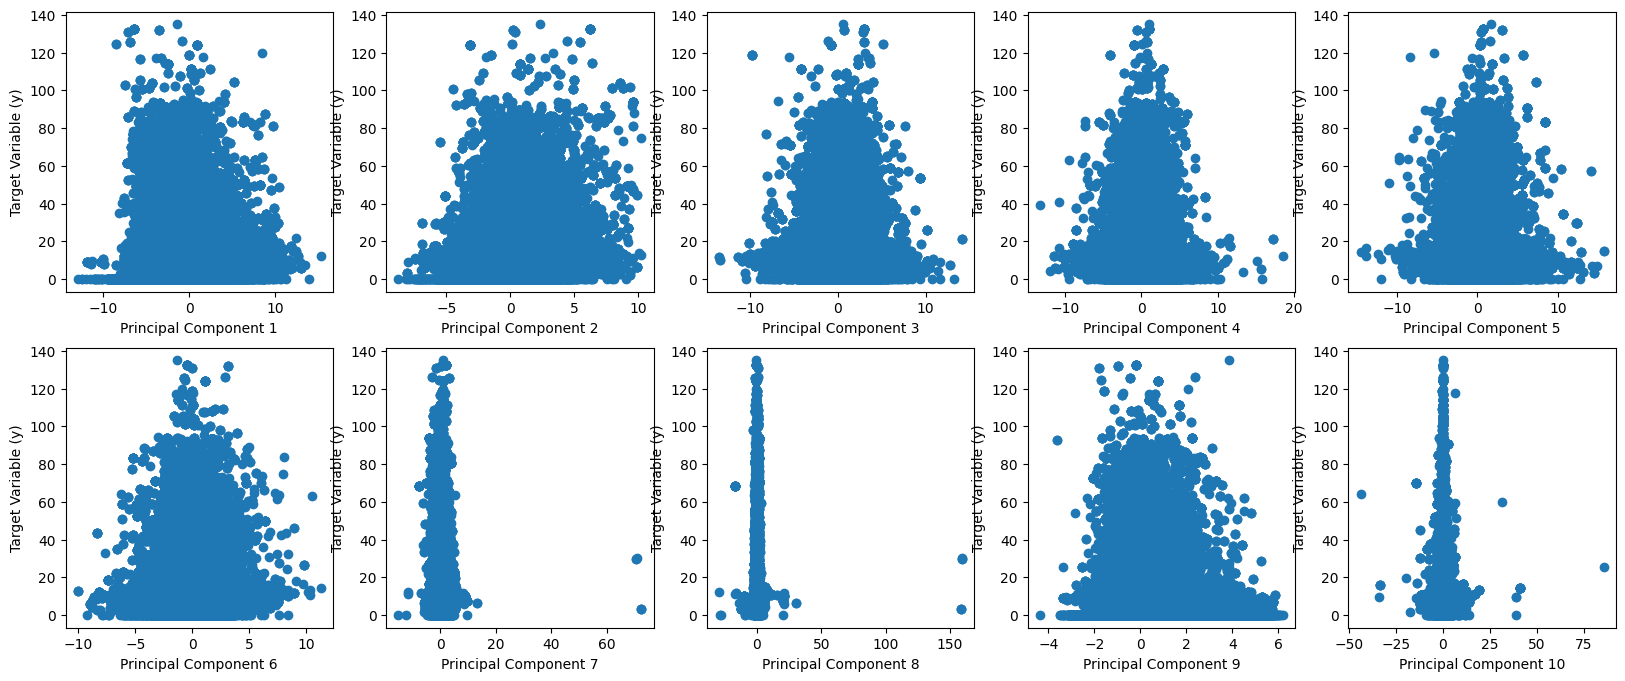

In [32]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Loop over the principal components
for i in range(X_pca.shape[1]):
    # Create a scatter plot of the principal component against the target variable
    axs[i].scatter(X_pca[:, i], y)
    
    # Add a label for the x-axis
    axs[i].set_xlabel('Principal Component {}'.format(i+1))
    
    # Add a label for the y-axis
    axs[i].set_ylabel('Target Variable (y)')
    
# Hide the empty subplots
for i in range(X_pca.shape[1], len(axs)):
    axs[i].axis('off')
    
# Show the plot
plt.show()


In [34]:
##### Runs various models on X and y prepared above 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_pca = scaler.fit_transform(X_pca)

# Split the data into training and testing sets
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_pca, y.ravel(), test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models on the training data
if do_lr:
    lr.fit(X_4_train, y_4_train)
    y_4_pred_lr = lr.predict(X_4_test)
if do_dt:
    dt.fit(X_4_train, y_4_train)
    y_4_pred_dt = dt.predict(X_4_test)
if do_rf:
    rf.fit(X_4_train, y_4_train)    
    y_4_pred_rf = rf.predict(X_4_test)
if do_gb:
    y_4_pred_gb = gb.predict(X_4_test)    
    gb.fit(X_4_train, y_4_train)

# Make predictions on the test data

# Evaluate the models using mean squared error and R-squared
if do_lr:
    print("Linear Regression (All Sentinels + All Indices + PCA):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_lr)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_4_test, y_4_pred_lr)))
    print("R-squared: {:.2f}".format(r2_score(y_4_test, y_4_pred_lr)))
    print()

if do_dt:
    print("Decision Tree (All Sentinels + All Indices + PCA):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_dt)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_4_test, y_4_pred_dt)))
    print("R-squared: {:.2f}".format(r2_score(y_4_test, y_4_pred_dt)))
    print()
    
if do_rf:
    print("Random Forest (All Sentinels + All Indices + PCA):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_rf)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_4_test, y_4_pred_rf)))
    print("R-squared: {:.2f}".format(r2_score(y_4_test, y_4_pred_rf)))
    print()
    
if do_gb:
    print("Gradient Boosting (All Sentinels + All Indices + PCA):")
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_gb)))
    print("Mean Absolute Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_gb)))
    print("R-squared: {:.2f}".format(r2_score(y_4_test, y_4_pred_gb)))
    print()


Random Forest (All Sentinels + All Indices + PCA):
Mean Squared Error: 21.45
Mean Absolute Error: 1.66
R-squared: 0.87



In [78]:
acc = custom_acc(y_4_test, y_4_pred_rf)
print(acc)

0.8235757575757487


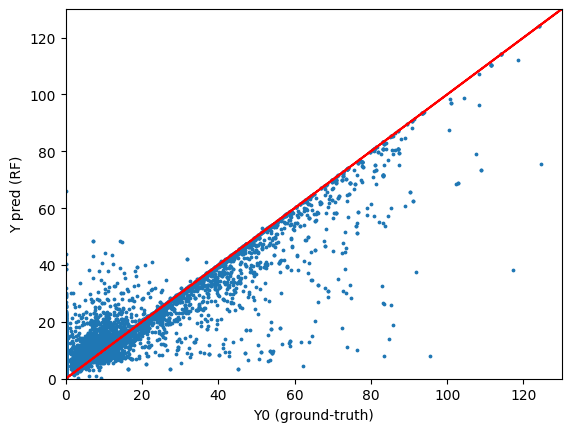

In [41]:
plt.scatter(y_4_test, y_4_pred_rf,s=3)
plt.plot(y_test, y_test,color='r')
plt.ylim(0,130)
plt.xlim(0,130)
plt.xlabel("Y0 (ground-truth)")
plt.ylabel("Y pred (RF)")
plt.show()

In [ ]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_4_train, y_4_train)
    y_4_pred = grid_search.predict(X_4_test)
    mse = mean_squared_error(y_4_test, y_4_pred)
    mae = mean_absolute_error(y_4_test, y_4_pred)
    r2 = r2_score(y_4_test, y_4_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "MAE:", mae, "R-squared:", r2)

In [ ]:
### Learning Curve: Random Forest Regressor with MSE (fewer rows) 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X_pca), size= 50000, replace=False)
X_4_subset = X_pca[subset_idx]
y_4_subset = y[subset_idx]

# Create an instance of the Random Forest model
rf_4_model = RandomForestRegressor()

# Define the range of training set sizes to use
train_4_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train_4_sizes, train_4_scores, test_4_scores = learning_curve(rf_4_model, X_4_subset, y_4_subset, cv=5, train_sizes=train_4_sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train_4_scores = -train_4_scores
test_4_scores = -test_4_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_4_scores_mean = np.mean(train_4_scores, axis=1)
train_4_scores_std = np.std(train_4_scores, axis=1)
test_4_scores_mean = np.mean(test_4_scores, axis=1)
test_4_scores_std = np.std(test_4_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_4_sizes, train_4_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_4_sizes, test_4_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: PCA')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

## RFE : Recursive Feature Elimination

In [35]:
#### RFE to improve features selection 
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the number of features to keep
n_features_to_keep = 10

# Create the RFE object and fit the data
model = RandomForestRegressor(random_state=42)
rfe = RFE(model, n_features_to_select=n_features_to_keep)
rfe.fit(X_rich_S2, y)

# Print the ranking of each feature
print('Feature ranking for Random Forest:', rfe.ranking_)

# Obtain the selected features
selected_features = X_rich_S2[:, rfe.support_]

# Create the new feature matrix
X_ref = np.hstack((selected_features, y.reshape(-1, 1)))

# Split the data into training and testing sets
n_samples = X_ref.shape[0]
n_train = int(0.8 * n_samples)
X_train, y_train = X_ref[:n_train, :-1], X_ref[:n_train, -1]
X_test, y_test = X_ref[n_train:, :-1], X_ref[n_train:, -1]

# Fit a random forest regression model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the mean squared error, mean absolute error, and R2 score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the mean squared error, mean absolute error, and R2 score
print('Mean squared error:', mse)
print('Mean absolute error:', mae)
print('R2 score:', r2)

Feature ranking for Random Forest: [ 4 16  9 11  1  6  1  1  1 10 13 18 19 20 24 23  7 12 21 14 15  5 17 22
  1  3  1  1  1  2  1  8  1]
Mean squared error: 19.412727564923202
Mean absolute error: 1.5406162376357877
R2 score: 0.8808877635496384


In [79]:
acc = custom_acc(y_test, y_pred)
print(acc)

0.323969696969696


In [ ]:
print("Here's the most important features:")
for i, rank in enumerate(rfe.ranking_):
    print(f"{feature_names[i]}: {rank}")

In [ ]:
## Learning Curve for MSE (Random Forest with standard parameters) on X_ref 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X_ref), size= 50000, replace=False)
X_4_subset = X_ref[subset_idx, :-1]
y_4_subset = y[subset_idx]

# Create an instance of the Random Forest model
rf_4_model = RandomForestRegressor()

# Define the range of training set sizes to use
train_4_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train_4_sizes, train_4_scores, test_4_scores = learning_curve(rf_4_model, X_4_subset, y_4_subset, cv=5, train_sizes=train_4_sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train_4_scores = -train_4_scores
test_4_scores = -test_4_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_4_scores_mean = np.mean(train_4_scores, axis=1)
train_4_scores_std = np.std(train_4_scores, axis=1)
test_4_scores_mean = np.mean(test_4_scores, axis=1)
test_4_scores_std = np.std(test_4_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_4_sizes, train_4_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_4_sizes, test_4_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model after REF')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

In [ ]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "MAE:", mae, "R-squared:", r2)


In [ ]:
## Learning Curve for MAE (optimal Random Forest Model on X_ref): 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the best hyperparameters
params = {'max_depth': 15, 'n_estimators': 300}

# Create an instance of the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(**params)

# Calculate the learning curve
train_5_sizes, train_5_scores, test_5_scores = learning_curve(rf_model, X_ref, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_5_scores_mean = -np.mean(train_5_scores, axis=1)
train_5_scores_std = np.std(train_5_scores, axis=1)
test_5_scores_mean = -np.mean(test_5_scores, axis=1)
test_5_scores_std = np.std(test_5_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_5_sizes, train_5_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_5_sizes, test_5_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Number of training examples')
plt.ylabel('Mean absolute error')
plt.title('Random Forest Learning Curve Sentinel-1 and Sentinel-2') 
plt.legend()
plt.show()

In [ ]:
## Learning curve for MSE (optimal Random Forest model on X_ref)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the best hyperparameters
params = {'max_depth': 15, 'n_estimators': 300}

# Create an instance of the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(**params)

# Calculate the learning curve
train_6_sizes, train_6_scores, test_6_scores = learning_curve(rf_model, X_ref, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_6_scores_mean = -np.mean(train_6_scores, axis=1)
train_6_scores_std = np.std(train_6_scores, axis=1)
test_6_scores_mean = -np.mean(test_6_scores, axis=1)
test_6_scores_std = np.std(test_6_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_6_sizes, train_6_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_6_sizes, test_6_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Number of training examples')
plt.ylabel('Mean Squared error')
plt.title('Random Forest Learning Curve (Optimal) on X_ref: Sentinel-1 + Sentinel-2 + Indices') 
plt.legend()
plt.show()